# Лабораторная работа №10 “Градиентный бустинг”

### *Для выполнения задания используйте набор данных boston из библиотеки sklearn* 
### *https://scikit-learn.org/stable/datasets/index.html#boston-dataset*

## **Задание**

### 1. Загрузите данные с помощью библиотеки sklearn.

In [32]:
import math

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
boston_dataset = datasets.load_boston()
X, y = boston_dataset.data, boston_dataset.target
features = boston_dataset.feature_names

### 2. Разделите выборку на обучающую (75%) и контрольную (25%).

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=25)

### 4. Заведите массив для объектов DecisionTreeRegressor (они будут использоваться в качестве базовых алгоритмов) и для вещественных чисел (коэффициенты перед базовыми алгоритмами).

In [6]:
algos, coefs = [], []

### 5. В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с отклонением истинных значений от предсказанных.

In [16]:
def grad(z, y):
    return y - z

def gbm_predict(X, base_algorithms_list, coefficients_list):
    return [sum([coeff * algo.predict([x])[0] 
                 for algo, coeff in zip(base_algorithms_list, 
                                        coefficients_list)]) 
            for x in X]

def gbm_train(X_train, y_train, max_depth=5, iters=50, coef=0.5):
    algos, coefs = [], []
    
    target = y_train
    for i in range(iters):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        tree.fit(X_train, target)
        algos.append(tree)
        
        if isinstance(coef, (int, float)):
            coefs.append(coef)
        else:
            coefs.append(coef(i))
            
        target = grad(gbm_predict(X_train, algos, coefs), y_train)
        
    return algos, coefs

In [17]:
algos, coefs = gbm_train(X_train, y_train)
print('mse: ', mean_squared_error(y_test, gbm_predict(X_test, algos, coefs)))

mse:  11.250394638914269


### 6. Попробуйте всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но на стандартном наборе данных будет всего 50 деревьев, возьмите для начала шаг побольше.

In [18]:
algos, coefs = gbm_train(X_train, y_train, coef=0.9)
print('mse: ', mean_squared_error(y_test, gbm_predict(X_test, algos, coefs)))

mse:  18.526252573073585


### 7.  процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X. Реализуйте ее. Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics.

In [19]:
def gbm_predict(X, base_algorithms_list, coefficients_list):
    return [sum([coeff * algo.predict([x])[0] 
                 for algo, coeff in zip(base_algorithms_list, 
                                        coefficients_list)]) 
            for x in X]

### 8. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Какое получилось качество на контрольной выборке?

In [25]:
algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.9 / (1.0 + i))
mse = mean_squared_error(y_test, gbm_predict(X_test, algos, coefs))
                         
print('mse: {:.4}, rmse: {:.4}'.format(mse, math.sqrt(mse)))

mse: 15.36, rmse: 3.92


### 9. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций, а также с ростом глубины деревьев. Постройте графики. Какие выводы можно сделать?

In [26]:
algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.1, iters=100)

In [44]:
metrics = []

for i in range(100):
    pred = gbm_predict(X_test, algos[:i], coefs[:i])
    rmse = math.sqrt(mean_squared_error(y_test, pred))
    metrics.append(rmse)

Text(0, 0.5, 'RMSE')

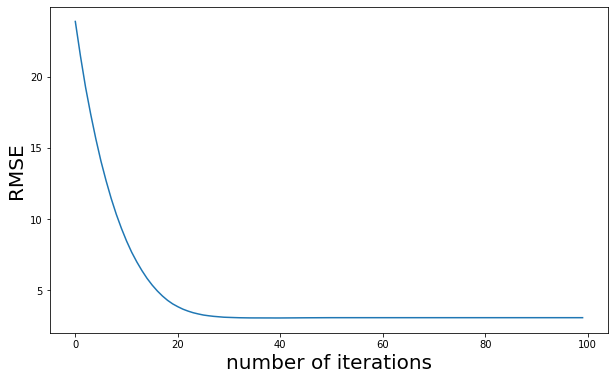

In [45]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(100), metrics)
plt.xlabel('number of iterations', size=20)
plt.ylabel('RMSE', size=20)

In [46]:
metrics = []

for depth in [3, 5, 10]:
    algos, coefs = gbm_train(X_train, y_train, coef=lambda i: 0.1, max_depth=depth)
    rmse = math.sqrt(mean_squared_error(y_test, gbm_predict(X_test, algos, coefs)))
    metrics.append(rmse)

Text(0, 0.5, 'RMSE')

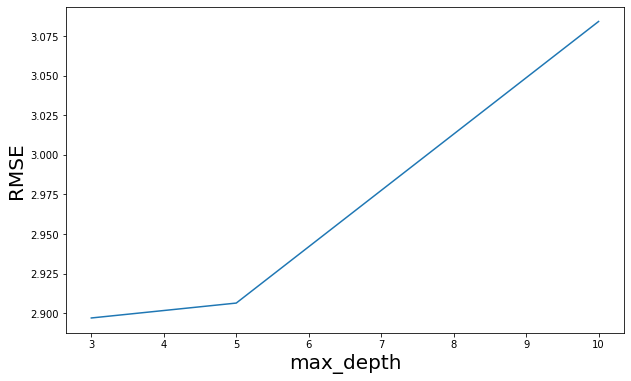

In [48]:
plt.figure(figsize=(10,6))

plt.plot([3, 5, 10], metrics)
plt.xlabel('max_depth', size=20)
plt.ylabel('RMSE', size=20)

Из графиков видно, что начиная примерно с 25-ой итерации качество градиентного бустинга почти не изменяется (улучшаясь до этого), а при увеличении глубины деревьев бустинг начинает переобучаться.

### 10. Сравните качество, получаемое с помощью градиентного бустинга с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE.

In [ ]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

predictions = linear_regression.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, predictions))

print('rmse for linear regression: {} (gradient boosting 3.92)'.format(rmse))

Ошибка чуть меньше в случае использования градиентного бустинга.